[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Atharva\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(15000, 10)
(500, 10)


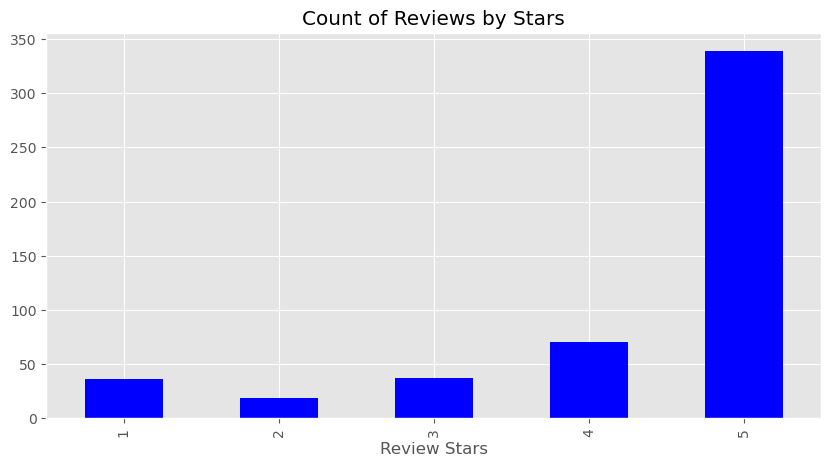

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Atharva\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Atharva\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Atharva\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Atharva\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


  0%|          | 0/500 [00:00<?, ?it/s]

(500, 14)


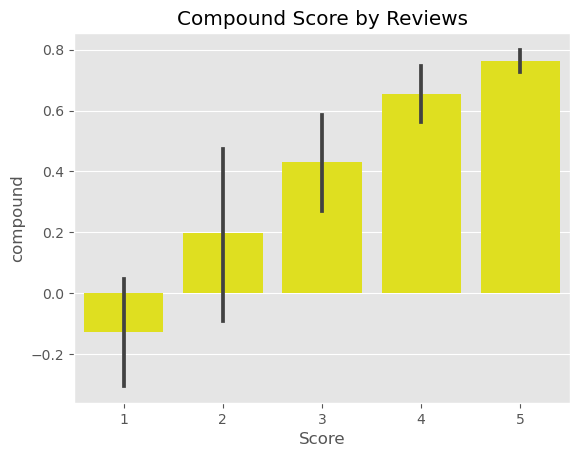

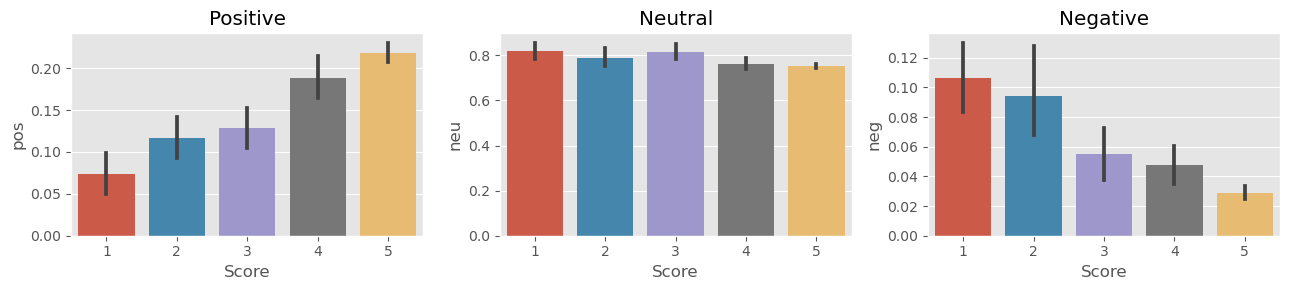

ImportError: 
AutoModelForSequenceClassification requires the PyTorch library but it was not found in your environment.
However, we were able to find a TensorFlow installation. TensorFlow classes begin
with "TF", but are otherwise identically named to our PyTorch classes. This
means that the TF equivalent of the class you tried to import would be "TFAutoModelForSequenceClassification".
If you want to use TensorFlow, please use TF classes instead!

If you really do want to use PyTorch please go to
https://pytorch.org/get-started/locally/ and follow the instructions that
match your environment.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')
plt.style.use('ggplot')

# reading of the data
df = pd.read_csv('Reviews.csv')
print(df.shape)
df = df.head(500)
print(df.shape)

df.head()

ax = df['Score'].value_counts().sort_index() .plot(kind= 'bar', title = 'Count of Reviews by Stars',figsize= (10,5), color ='blue')
ax.set_xlabel('Review Stars')
plt.show()

example = df["Text"][50]
print(example)

tokens = nltk.word_tokenize(example)

tokens[:10]
# tokens = nltk.sent_tokenize(example)
# print(tokens)

#pos tagging
nltk.download('averaged_perceptron_tagger')
tagged = nltk.pos_tag(tokens)
tagged[:10]

# chunking
nltk.download('maxent_ne_chunker')
nltk.download('words')
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()



from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

sia.polarity_scores('I am sad!')

sia.polarity_scores('I am happy!')

sia.polarity_scores('I hate you but I like your good qualities')

sia.polarity_scores(example)

res = {}
for i, row in tqdm(df.iterrows(), total= len(df)):
  text = row['Text']
  myid = row['Id']
  res[myid] = sia.polarity_scores(text)

vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index':'Id'})
vaders = vaders.merge(df, how = 'left')
vaders.head()

print(vaders.shape)

# ploting the vader results
ax = sns.barplot(data = vaders, x = 'Score', y = 'compound', color = 'yellow')
ax.set_title('Compound Score by Reviews')
plt.show()

fig, axs = plt.subplots(1,3, figsize = (13,3))
sns.barplot(data = vaders, x ='Score', y = 'pos', ax = axs[0])
sns.barplot(data = vaders, x ='Score', y = 'neu', ax = axs[1])
sns.barplot(data = vaders, x ='Score', y = 'neg', ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
# fig.subplots_adjust(left= 0.1 , right = 0.9, bottom = 0.1, top = 0.9, wspace = 0.4, hspace = 0.4)
plt.show()



from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model =AutoModelForSequenceClassification.from_pretrained(MODEL)

#vader results
print(example)
sia.polarity_scores(example)

# Roberta Model
# !pip install torch torchvision
encoded_text = tokenizer(example, return_tensors = 'pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors = 'pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
  }
  return scores_dict

res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
  try:
    text = row['Text']
    myid = row['Id']
    vader_result = sia.polarity_scores(text)
    vader_result_rename= {}
    for key, value in vader_result.items():
      vader_result_rename[f"vader_{key}"] = value
    roberta_result = polarity_scores_roberta(text)
    both = {**vader_result_rename, **roberta_result}
    res[myid] = both
  except RuntimeError:
    print(f'Broke for id {myid}')

result_df = pd.DataFrame(res).T
result_df = result_df.reset_index().rename(columns= {'index':'Id'})
result_df = result_df.merge(df, how = 'left')

#compare the scores of vader and Roberta
result_df.columns
print(result_df.shape)

sns.pairplot(data = result_df, vars = ['vader_neg', 'vader_neu', 'vader_pos', 'roberta_neg', 'roberta_neu', 'roberta_pos'], hue = 'Score', palette = 'tab10')
plt.show()

In [ ]:
pip install transformers


In [ ]:
pip install pytorch

In [ ]:
pip install torch